# 过拟合与正则项


*Ref:* 

https://en.wikipedia.org/wiki/Regularization_(mathematics)

​http://cs229.stanford.edu/notes/cs229-notes5.pdf

Bishop: Chapter 1.1 

In [27]:
import numpy as np
import math
import torch
import torch.optim as optim
from matplotlib import pyplot as plt

## 生成数据

将 $sin(2\pi x)$ 在$(0,1)$区间上按均匀分布采样9个数据点 并添加噪声

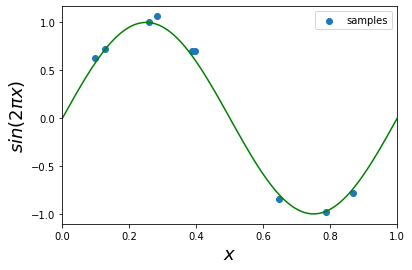

In [28]:
x = torch.rand(9)
y = torch.sin(2*math.pi*x) + 0.05 * torch.randn(len(x))

fig, ax = plt.subplots()
xdata = torch.linspace(0, 1, 200)
ax.scatter(x, y, label='samples')
ax.plot(xdata, torch.sin(2*math.pi*xdata), 'g')
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$sin(2\pi x)$", fontsize=18)
ax.legend()

## 拟合
用 $n$ 次多项式拟合这些点, 即 $$y=\sum_{i=0}^{n} w_{i} x^{i}$$ 观察不同的 $n$ 的拟合效果

In [29]:
# 多项式函数
def f(x,w):
    y_p = 0
    for i in range(len(w)):
        y_p += pow(x,i) * w[i]
    return y_p

In [30]:
# mean square error 
def loss_fn(y_p, y):
  squared_diffs = (y_p - y)**2
  return squared_diffs.mean()

In [31]:
# 拟合过程 (手写梯度下降)
def training_loop1(n_epochs, learning_rate, params, x, y):
  for epoch in range(1, n_epochs + 1):
    if params.grad is not None:
      params.grad.zero_()
    y_p = f(x, params)
    loss = loss_fn(y_p, y)
    loss.backward()
    with torch.no_grad():
      params -= learning_rate * params.grad
    if epoch % 5000 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))
  return params

In [33]:
# 拟合过程 (借助 torch.optim 内置的算法)
def training_loop2(n_epochs, optimizer, params, x, y):
  for epoch in range(1, n_epochs + 1):
    y_p = f(x, params)
    loss = loss_fn(y_p, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 5000 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))
  return params

In [44]:
# n = 1
w = torch.randn(2, requires_grad=True)
w_l = training_loop1(n_epochs=10000, learning_rate=1e-2, params=w, x=x, y=y)

w = w_l.detach().numpy()
print("多项式系数为：",w)
fig, ax = plt.subplots()
xdata = torch.linspace(0, 1, 200)
ax.scatter(x, y, label='samples')
ax.plot(xdata, torch.sin(2*math.pi*xdata), 'g')
ax.plot(xdata, f(xdata, w), 'r')
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$sin(2\pi x)$", fontsize=18)
ax.legend()
  

Epoch 5000, Loss 0.137593
Epoch 10000, Loss 0.137591
多项式系数为： [ 1.401795 -2.703003]


Epoch 5000, Loss 0.003325
Epoch 10000, Loss 0.003268
多项式系数为： [ -0.56130666  15.635728   -43.3456      28.872782  ]


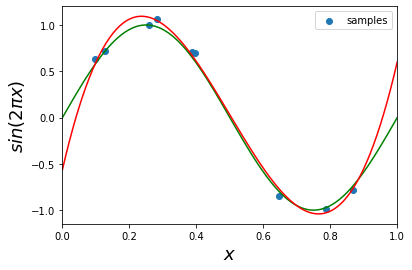

In [45]:
# n = 3
w = torch.randn(4, requires_grad=True)

learning_rate = 1e-1
optimizer = optim.Adam([w], lr=learning_rate)
w_l = training_loop2(
      n_epochs = 10000,
      optimizer = optimizer,
      params = w,
      x = x,
      y = y)

w = w_l.detach().numpy()
print("多项式系数为：",w)
fig, ax = plt.subplots()
xdata = torch.linspace(0, 1, 200)
ax.scatter(x, y, label='samples')
ax.plot(xdata, torch.sin(2*math.pi*xdata), 'g')
ax.plot(xdata, f(xdata, w), 'r')
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$sin(2\pi x)$", fontsize=18)
ax.legend()

In [48]:
# n = 9
w = torch.randn(10, requires_grad=True)

learning_rate = 1e-1
optimizer = optim.Adam([w], lr=learning_rate)
w_l = training_loop2(
      n_epochs = 50000,
      optimizer = optimizer,
      params = w,
      x = x,
      y = y)

w = w_l.detach().numpy()
print("多项式系数为：",w)
fig, ax = plt.subplots()
xdata = torch.linspace(0, 1, 200)
ax.scatter(x, y, label='samples')
ax.plot(xdata, torch.sin(2*math.pi*xdata), 'g')
ax.plot(xdata, f(xdata, w), 'r')
ax.set_xlim(0, 1)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$sin(2\pi x)$", fontsize=18)
ax.legend()

Epoch 5000, Loss 0.000898
Epoch 10000, Loss 0.001632
Epoch 15000, Loss 0.000720
Epoch 20000, Loss 0.000678
Epoch 25000, Loss 0.000650
Epoch 30000, Loss 0.000631
Epoch 35000, Loss 0.000618
Epoch 40000, Loss 0.000609
Epoch 45000, Loss 0.000603
Epoch 50000, Loss 0.000599
多项式系数为： [  0.03773072   6.788386    -7.131937   -16.712702    -4.5273685
  14.387991    19.058187    11.375723    -2.791285   -22.890226  ]


## 添加正则项
为解决过度拟合的问题，对9次多项式模型的损失函数添加正则项，即

观察不同的 $\lambda$ 对拟合效果的影响

lambda =   0
Epoch 0, Loss 0.466821
Epoch 5000, Loss 0.000773
Epoch 10000, Loss 0.000715
Epoch 15000, Loss 0.000676
Epoch 20000, Loss 0.000650
Epoch 25000, Loss 0.000632
Epoch 30000, Loss 0.000620
Epoch 35000, Loss 0.000611
Epoch 40000, Loss 0.000618
Epoch 45000, Loss 0.000602
lambda =   0.001
Epoch 0, Loss 0.725502
Epoch 5000, Loss 0.036148
Epoch 10000, Loss 0.036213
Epoch 15000, Loss 0.036125
Epoch 20000, Loss 0.036142
Epoch 25000, Loss 0.036179
Epoch 30000, Loss 0.036199
Epoch 35000, Loss 0.036287
Epoch 40000, Loss 0.036132
Epoch 45000, Loss 0.036138
lambda =   10
Epoch 0, Loss 90.520576
Epoch 5000, Loss 1.471879
Epoch 10000, Loss 1.951488
Epoch 15000, Loss 1.908199
Epoch 20000, Loss 1.702326
Epoch 25000, Loss 1.611881
Epoch 30000, Loss 1.957889
Epoch 35000, Loss 2.321740
Epoch 40000, Loss 2.198838
Epoch 45000, Loss 2.381381
[[ 4.04004194e-02  6.76439285e+00 -7.14101028e+00 -1.65879822e+01
  -3.60724187e+00  1.13098860e+01  2.10110626e+01  1.20278826e+01
  -2.07917428e+00 -2.4210292

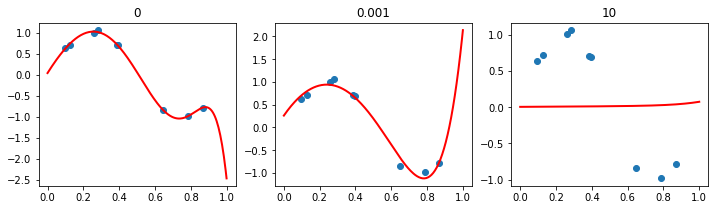

In [63]:
# L1 正则项
lmbda = [0, 0.001, 10]
learning_rate = 1e-1
W = np.zeros((3,10))

for j in range(len(lmbda)):
  print("lambda =  ",lmbda[j])
  w = torch.randn(10, requires_grad=True)
  optimizer = optim.Adam([w], lr=learning_rate)
  for epoch in range(50000):
    y_pred = f(x, w)
    loss = (y_pred - y).pow(2).mean() + lmbda[j] * (w.abs().sum())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5000 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))
  W[j,:] = w.detach().numpy()
print(W)

fig, axes = plt.subplots(1, 3, figsize=(12,3))
xdata = np.linspace(0, 1, 200)
for i in range(3):
  axes[i].scatter(x, y)
  axes[i].plot(xdata, f(xdata, W[i,:]), 'r', lw=2)
  axes[i].set_title(lmbda[i])

lambda =   0
Epoch 0, Loss 1.227617
Epoch 5000, Loss 0.000886
Epoch 10000, Loss 0.000756
Epoch 15000, Loss 0.000704
Epoch 20000, Loss 0.001794
Epoch 25000, Loss 0.000648
Epoch 30000, Loss 0.000629
Epoch 35000, Loss 0.000618
Epoch 40000, Loss 0.000611
Epoch 45000, Loss 0.000606
lambda =   0.001
Epoch 0, Loss 0.427773
Epoch 5000, Loss 0.070906
Epoch 10000, Loss 0.070906
Epoch 15000, Loss 0.070906
Epoch 20000, Loss 0.070907
Epoch 25000, Loss 0.070906
Epoch 30000, Loss 0.070906
Epoch 35000, Loss 0.070927
Epoch 40000, Loss 0.070906
Epoch 45000, Loss 0.070907
lambda =   10
Epoch 0, Loss 109.171562
Epoch 5000, Loss 0.691272
Epoch 10000, Loss 0.691272
Epoch 15000, Loss 0.691272
Epoch 20000, Loss 0.691272
Epoch 25000, Loss 0.691272
Epoch 30000, Loss 0.691272
Epoch 35000, Loss 0.691272
Epoch 40000, Loss 0.691272
Epoch 45000, Loss 0.691272
[[ 3.26279514e-02  6.85425520e+00 -7.57207775e+00 -1.57736921e+01
  -4.43422174e+00  1.24483976e+01  1.95551071e+01  1.20182791e+01
  -7.51295030e-01 -2.485974

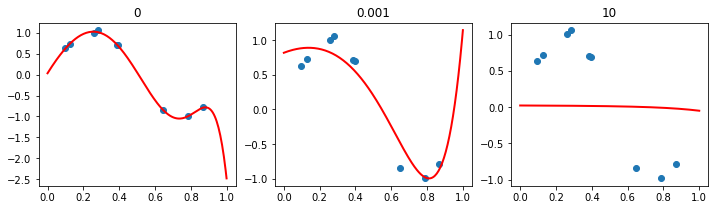

In [62]:
# L2 正则项
lmbda = [0, 0.001, 10]
learning_rate = 1e-1
W = np.zeros((3,10))

for j in range(len(lmbda)):
  print("lambda =  ",lmbda[j])
  w = torch.randn(10, requires_grad=True)
  optimizer = optim.Adam([w], lr=learning_rate)
  for epoch in range(50000):
    y_pred = f(x, w)
    loss = (y_pred - y).pow(2).mean() + lmbda[j] * torch.sum(w*w)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 5000 == 0:
      print('Epoch %d, Loss %f' % (epoch, float(loss)))
  W[j,:] = w.detach().numpy()
print(W)

fig, axes = plt.subplots(1, 3, figsize=(12,3))
xdata = np.linspace(0, 1, 200)
for i in range(3):
  axes[i].scatter(x, y)
  axes[i].plot(xdata, f(xdata, W[i,:]), 'r', lw=2)
  axes[i].set_title(lmbda[i])
  